# Data Acquisition

<span style="padding-left: 28px;">**<font size=4>Data Science - Capstone Project Submission</font>**</span>

* Student Name: **James Toop**
* Student Pace: **Self Paced**
* Scheduled project review date/time: **29th October 2021 @ 21:30 BST**
* Instructor name: **Jeff Herman / James Irving**
* Blog URL: **https://toopster.github.io/**
---

This section presents code and instructions for downloading each dataset.

**IMPORTANT NOTE:**

The datasets and transformed JSON files have not been included in the GitHub repository with this notebook and will need to be downloaded and
stored in the local repository for the code to run correctly.  

The code below will however, download, store and transform the datasets as required for the models to run. But, to ensure ease of use, it is also possible to download the raw and transformed datasets using [this link](https://drive.google.com/file/d/11lKYIZiwEQJ-pp0G1bJPHXLJLj8uKPqW/view?usp=sharing).

In [ ]:
# Import required libraries and modules for data acquisition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
from pathlib import Path
import shutil

## Download Speech Commands dataset

A dataset for limited-vocabulary speech recognition by Pete Warden, TensorFlow team at Google.

https://arxiv.org/abs/1804.03209

The Speech Commands dataset is an attempt to build a standard training and evaluation dataset for a class of simple speech recognition tasks. Its primary goal is to provide a way to build and test small models that detect when a single word is spoken, from a set of ten or fewer target words, with as few false background noise or unrelated speech.

In [3]:
def download_speech_commands():    
    '''
    Downloads and unpacks the speech commands dataset, removing any 
    unnecessary files
    '''   
    data_dir = pathlib.Path('data/speech_commands_v0.02')
    origin = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
    
    # Check to see if data directory already exists, download if not
    if not data_dir.exists():
        tf.keras.utils.get_file(
            'speech_commands_v0.02.zip',
            origin=origin,
            extract=True,
            cache_dir='.',
            cache_subdir='data/speech_commands_v0.02')
    else:
        print('Speech Commands dataset already exists')
        
    # Remove the _background_noise_ samples as these are not required
    try:
        shutil.rmtree(str(data_dir) + '/_background_noise_')
    except OSError as e:
        print('Error: %s - %s.' % (e.filename, e.strerror),
              'Check if directory has already been removed.')
    
    
    # Remove the extracted zip file for politeness as this is not required
    zip_file = str(data_dir) + '/speech_commands_v0.02.zip'
    if os.path.exists(zip_file):
        os.remove(zip_file)

In [3]:
# Call the function to download the Speech Commands v0.02 dataset
download_speech_commands()

Speech Commands dataset already exists
Error: data/speech_commands_v0.02/_background_noise_ - No such file or directory. Check if directory has already been removed.


## Download the Ultrasuite dataset

A collection of ultrasound and acoustic speech data from child speech therapy sessions – University of Edinburgh, School of Infomatics

https://ultrasuite.github.io/

Ultrasuite is a collection of ultrasound and acoustic speech data from child speech therapy sessions. The current release includes three datasets, one from typically developing children and two from speech disordered children:

* **[Ultrax Typically Developing (UXTD)](https://ultrasuite.github.io/data/uxtd/)** -  A dataset of 58 typically developing children. 
* **[Ultrax Speech Sound Disorders (UXSSD)](https://ultrasuite.github.io/data/uxssd/)** - A dataset of 8 children with speech sound disorders. 
* **[UltraPhonix (UPX)](https://ultrasuite.github.io/data/upx/)** - A second dataset of children with speech sound disorders, collected from 20 children.

<small>
<strong>Source:</strong><br/>
Eshky, A., Ribeiro, M. S., Cleland, J., Richmond, K., Roxburgh, Z., Scobbie, J., & Wrench, A. (2018) Ultrasuite: A repository of ultrasound and acoustic data from child speech therapy sessions. Proceedings of INTERSPEECH. Hyderabad, India. [<a target="_blank" href="https://ultrasuite.github.io/papers/ultrasuite_IS18.pdf">paper</a>]
</small>

In [13]:
# Function for downloading the Ultrasuite datasets
def download_ultrasuite(datasets):
    '''
    Sets up a remote sync for the Ultrasuite datasets and labels 
        
        Params:
            datasets (list): Specific ultrasuite dataset to sync can be 'upx', 'uxtd' or 'uxssd'
            
    '''    
    orig_loc = Path.cwd()
    data_dir = pathlib.Path('data/ultrasuite')
    
    # Check to see if data directory already exists, download if not
    if not os.path.isdir(data_dir):
        os.makedirs(data_dir)
        
        # Change working directory
        os.chdir(data_dir)
        
        for dataset in datasets:
            os.system('rsync -av --include="*/" --include="*.wav" --exclude="*" ultrasuite-rsync.inf.ed.ac.uk::ultrasuite/core-' + dataset + ' .')
            print(dataset, 'dataset has been downloaded.')
        
        os.system('rsync -av ultrasuite-rsync.inf.ed.ac.uk::ultrasuite/labels-uxtd-uxssd-upx .')
        print('The ultrasuite labels have been downloaded.')
        
        # Change working directory back
        os.chdir(orig_loc)

In [14]:
# Download the Ultrasuite datasets
download_ultrasuite(['upx', 'uxtd', 'uxssd'])

upx dataset has been downloaded.
uxtd dataset has been downloaded.
uxssd dataset has been downloaded.
The labels have been downloaded.


In [61]:
def ultrasuite_word_labels(src_dataset, src_file):
    '''
    Extracts the labels from a single *.lab file into a single DataFrame
        
        Params:
            src_dataset (str): Dataset name of the target *.lab file
            src_file (str): Filename of the target *.lab file
        
        Returns:
            word_labels_df (pandas.core.frame.DataFrame): 
            DataFrame containing the labels (utterances), timestamps, speaker and session from the *.lab file
    '''      
    filepath = 'data/ultrasuite/labels-uxtd-uxssd-upx/' + src_dataset + '/word_labels/lab/' + src_file

    columns = ['start_time', 'end_time', 'utterance']
    word_labels_df = pd.DataFrame()
    word_labels_df = pd.read_csv(filepath, sep=" ", header=None, names=columns)
    
    # Extract the speaker, session and speech data from the filename and add to the dataframe
    word_labels_df['dataset'] = src_dataset
    word_labels_df['speaker'] = src_file[0:3]
    if len(src_file[4:-9]) == 0:
        word_labels_df['session'] = None
    else:
        word_labels_df['session'] = src_file[4:-9]
    word_labels_df['speech_waveform'] = src_file[-8:-4]

    # Tidy up data formatting and correct time based units
    word_labels_df['utterance'] = word_labels_df['utterance'].str.lower()
    word_labels_df['start_time'] = pd.to_timedelta(word_labels_df['start_time'] * 100)
    word_labels_df['end_time'] = pd.to_timedelta(word_labels_df['end_time'] * 100)
    
    return word_labels_df

In [62]:
# Quick test to check function works for a single labels file
upx_01F_df = ultrasuite_word_labels('upx', '01F-BL1-005A.lab')
upx_01F_df.head()

,start_time,end_time,utterance,dataset,speaker,session,speech_waveform
0,00:00:00,00:00:00.620000,teeth,upx,01F,BL1,005A
1,00:00:03.860000,00:00:04.650000,watch,upx,01F,BL1,005A
2,00:00:06.160000,00:00:06.780000,orange,upx,01F,BL1,005A
3,00:00:09.050000,00:00:09.980000,school,upx,01F,BL1,005A


In [38]:
def extract_segments(y, sr, segments, dataset):
    '''
    Extracts audio segments from the source *.wav file based on timestamps contained within the associated *.lab file
        
        Params:
            y (str): Path to input file
            sr (int): Sample Rate
            segments (DataFrame): DataFrame containing timestamps, labels, speaker and session data
            dataset (str): Specific ultrasuite dataset to process can be 'upx', 'uxtd' or 'uxssd'
    '''         
    # Compute segment regions in number of samples
    starts = np.floor(segments.start_time.dt.total_seconds() * sr).astype(int)
    ends = np.ceil(segments.end_time.dt.total_seconds() * sr).astype(int)
    
    isolated_directory = 'data/ultrasuite_isolated/' + dataset + '/'

    if not os.path.isdir(isolated_directory):
        os.makedirs(isolated_directory.strip('/'))
    
    i = 0
    # Slice the audio into segments
    for start, end in zip(starts, ends):
        audio_seg = y[start:end]
        print('extracting audio segment:', len(audio_seg), 'samples')
        
        # Set the file path for the spliced audio file    
        file_path = isolated_directory + str(segments.speaker[i]) + '/'
        if segments.session[i] != None:
            file_path = file_path + str(segments.session[i]) + '/' 
        file_path = file_path + str(segments.speech_waveform[i]) + '/'
            
        if not os.path.isdir(file_path):
            os.makedirs(file_path.strip('/')) 
            
        file_name = file_path + str(segments.utterance[i]) + '.wav'
        
        sf.write(file_name, audio_seg, sr)
        i += 1

In [39]:
def process_ultrasuite_wav_files(src_dataset, src_speaker, src_session):
    '''
    Processes and extracts audio segments for all Ultrasuite *.wav files
        
        Params:
            src_dataset (str): Ultrasuite dataset to process can be 'upx', 'uxtd' or 'uxssd'
            src_speaker (str): Speaker to process
            src_session (str): Session to process
            
    ''' 
    directory = 'data/ultrasuite/core-' + src_dataset + '/core/' + src_speaker + '/'
    
    # Set the target directory based on session if available
    if src_session != False:
         directory = directory + src_session + '/'

    # Loop through files in the directory, splice and rename files based on labels
    for filename in os.listdir(directory):

        if not filename[-5:-4] == 'E' or filename[-5:-4] == 'D':
            # Fetch the corresponding word labels and load into a DataFrame
            # Handle errors for when no labels exist
            # Files are graded on basis of quality and labels only available for high quality samples
            try:
                if src_session != False:
                    labels_filename = src_speaker + '-' + src_session + '-' + filename[-8:-4] + '.lab'
                else:
                    labels_filename = src_speaker + '-' + filename[-8:-4] + '.lab'
                
                labels_df = ultrasuite_word_labels(src_dataset, labels_filename)
                
                wav_path = directory + filename
                y, sr = librosa.load(wav_path, sr=16000)
                extract_segments(y, sr, labels_df, src_dataset)                
            
            except IOError:
                if src_session != False:
                    print('\n' + src_speaker + '-' + src_session + '-' + filename[-8:-4] + '.lab not found \n')
                else:
                    print('\n' + src_speaker + '-' + filename[-8:-4] + '.lab not found \n')

In [40]:
def process_all_wav_files(datasets):
    '''
    Processes and extracts audio segments for all Ultrasuite *.wav files
        
        Params:
            datasets (list): Ultrasuite dataset to process can be any or all of 'upx', 'uxtd', 'uxssd'        
    '''     
    # Loop through the datasets
    for dataset in datasets:
        current_dataset_dir = 'data/ultrasuite/core-' + dataset + '/core/'
        speakers = os.listdir(current_dataset_dir)
        
        # Loop through the speakers
        for speaker in speakers:
            current_speaker_dir = 'data/ultrasuite/core-' + dataset + '/core/' + speaker + '/'
            sessions = os.listdir(current_speaker_dir)

            # If there are multiple therapy sessions, loop through the sessions and process files
            for session in sessions:
                if os.path.isdir(os.path.join(current_speaker_dir, session)):
                    process_ultrasuite_wav_files(dataset, speaker, session)
                else:
                    process_ultrasuite_wav_files(dataset, speaker, False)

In [ ]:
# Splice all *.wav files for all datasets
# NOTE: This takes a long time to run
process_datasets = ['upx', 'uxssd', 'uxtd']
process_all_wav_files(process_datasets)

In [14]:
def pad_silence(target_length, input_filepath, output_filepath):
    '''
    Pad the spliced audio samples with silence so that they are all at least 1 second in length
        
        Params:
            target_length (int): Target length of final audio sample in milliseconds
            input_filepath (str): File path to input / original *.wav file
            output_filepath (str): File path to output / padded *.wav file
    '''      
    target_length = target_length
    audio = AudioSegment.from_wav(input_filepath)
    if len(audio) > target_length:
        print(str(input_filepath) , 'is longer that 1 second, no padding required.')
        silence = AudioSegment.silent(duration=0)
    else:
        silence = AudioSegment.silent(duration=target_length - len(audio) + 1)
        
    padded = audio + silence
    padded.export(output_filepath, format='wav')

In [42]:
def standardise_filing(datasets):
    '''
    Standardise filing structure for isolated samples, padding and renaming files in the process
        
        Params:
            datasets (list): Ultrasuite dataset to process can be any or all of 'upx', 'uxtd', 'uxssd'        
    '''     
    # Loop through the datasets
    for dataset in datasets:

        isolated_files = Path.cwd() / 'data/ultrasuite_isolated' / dataset

        for isolated_file in isolated_files.glob('**/*'):

            if isolated_file.is_file():

                filename = isolated_file.stem
                extension = isolated_file.suffix
                sourcedata = dataset
                sourcefile = isolated_file.parent.parts[-1]
                
                # Rename the file but don't lose the original references handling the different folder structures
                if dataset == 'uxtd':
                    speaker = isolated_file.parent.parts[-2] 
                    new_filename = f'{filename}_{dataset}-{speaker}-{sourcefile}{extension}'
                    
                else:
                    session = isolated_file.parent.parts[-2]
                    speaker = isolated_file.parent.parts[-3]
                    new_filename = f'{filename}_{dataset}-{speaker}-{session}-{sourcefile}{extension}'

                # Define the new file path and create directory if it doesn't exist
                new_path = Path.cwd() / 'data/ultrasuite_transformed' / filename

                if not new_path.exists():
                    new_path.mkdir(parents=True, exist_ok=True)

                new_file_path = new_path.joinpath(new_filename)

                # Pad audio sample if required and move to new location
                if extension == '.wav':
                    pad_silence(1000, str(isolated_file), str(new_file_path))

In [ ]:
# Run the function to standardise the filing for all Ultrasuite datasets
standardise_filing(['upx', 'uxssd', 'uxtd'])

#### Cleanse the Ultrasuite dataset

1. Only keep audio samples of actual words using NLTK WordNet as a source corpus
2. Remove audio samples of simple phonetic letters (from the `manual_remove` list)
3. Only keep audio samples that have more than 5 different samples


In [43]:
# Check to see if the WordNet corpus is available, download if not and import
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

from nltk.corpus import wordnet as wn

def remove_invalid_samples():
    '''
    Function to remove all 'invalid' audio samples based on predetermined criteria       
    '''     
    transformed_files = 'data/ultrasuite_transformed/'
    
    manual_remove = ['a']
    
    for name in sorted(os.listdir(transformed_files)):
        
        path = os.path.join(transformed_files, name)
        
        if os.path.isdir(path):
            num_samples = len(os.listdir(path))
        
            # Remove audio samples of words not listed in NLTK WordNet corpus
            if not wn.synsets(name) or len(name)==1:
                print(name, 'is NOT a valid word, removing', num_samples, 'samples')
                shutil.rmtree(path)
            # Remove audio samples where there are 5 or less samples
            elif num_samples <= 5: 
                print(name, 'does NOT have enough samples, removing', num_samples, 'samples')
                shutil.rmtree(path)
            # Remove audio samples based on our manually constructed list above
            elif name in manual_remove:
                print(name, 'is being manually removed', num_samples, 'samples')
                shutil.rmtree(path)
            else:
                print('---')
                print(name, 'is a valid word and there are', num_samples, 'samples:\n')

In [ ]:
# Remove invalid audio samples from the transformed dataset
remove_invalid_samples()

In [8]:
# Get the audio sample file information for the Ultrasuite dataset
ultrasuite_filestats = get_filestats('data/ultrasuite_transformed')
ultrasuite_filestats.head()

,sample_utterance,sample_filename,sample_duration,sample_samplerate
0,parch,parch_upx-05M-BL2-017A.wav,1.000938,16000
1,parch,parch_upx-05M-Mid-016A.wav,1.001000,16000
2,parch,parch_upx-05M-BL3-016A.wav,1.000875,16000
3,parch,parch_upx-05M-BL4-016A.wav,1.000875,16000
4,parch,parch_upx-05M-Maint-016A.wav,1.000875,16000


In [45]:
# Get the file information the audio samples for 'book'
ultrasuite_book = ultrasuite_filestats[(ultrasuite_filestats['sample_utterance'] == 'book')]
len(ultrasuite_book)

114

In [46]:
# Preview the dataframe
ultrasuite_book.head(20)

,sample_utterance,sample_filename,sample_duration,sample_samplerate
22389,book,book_uxssd-07F-Post-015A.wav,1.001000,16000
22390,book,book_uxtd-13F-045A.wav,1.000938,16000
22391,book,book_uxssd-06M-Mid-011A.wav,1.000938,16000
22392,book,book_uxssd-02M-Maint2-013A.wav,1.000938,16000
22393,book,book_uxssd-06M-Post-047A.wav,1.001000,16000
22394,book,book_uxssd-05M-Post-020A.wav,1.000938,16000
22395,book,book_upx-08M-Suit-014A.wav,1.000875,16000
22396,book,book_uxtd-16F-046A.wav,1.000938,16000
22397,book,book_upx-03F-Therapy_04-011A.wav,1.000938,16000
22398,book,book_uxssd-02M-BL2-027A.wav,1.001000,16000


In [9]:
# Check the total number of samples in the Ultrasuite dataset after preprocessing
len(ultrasuite_filestats)

33800

In [10]:
# Check how many samples that are longer than 1 second in duration are in the dataset
us_long_samples = ultrasuite_filestats[(ultrasuite_filestats['sample_duration'] > 1.0)]
len(us_long_samples)

33800

In [72]:
# Summarise the number of samples for each utterance
us_summary = (ultrasuite_filestats.groupby(['sample_utterance'])
                                  .size()
                                  .reset_index(name='count')
                                  .sort_values('count', ascending=False))
us_summary.head(35)

,sample_utterance,count
366,helicopter,292
700,say,290
961,watch,235
249,elephant,233
322,got,229
705,scissors,222
946,umbrella,222
274,fishing,222
814,spider,217
397,in,211


In [17]:
len(us_summary)

991

In [12]:
# Get the top 35 words with the largest number of samples
us_top35 = us_summary.head(35)
us_top35.sort_values('sample_utterance', ascending=True)

,sample_utterance,count
75,boy,148
84,bridge,198
106,cab,123
176,crab,122
237,ear,159
249,elephant,233
274,fishing,222
275,five,130
282,four,146
290,frog,178


In [97]:
# Function to copy top X number of keywords from the Ultrasuite transformed folder to a new folder
def copy_keywords(num_keywords, keywords):
    '''
    Copys the 'top' keywords based on number of samples to a new folder
        
        Params:
            num_keywords (int): Number of 'top' keywords to copy based on number of samples available
            keywords (DataFrame): DataFrame containing keywords sorted by number of samples
    '''
    src_directory = 'data/ultrasuite_transformed/'
    top_directory = 'data/ultrasuite_top' + str(num_keywords) + '/'
    
    sorted_keywords = keywords.reset_index()

    if not os.path.isdir(top_directory):
        os.makedirs(top_directory.strip('/'))
    
    i = 0
    while (i < num_keywords):
        src_folder = src_directory + sorted_keywords.sample_utterance[i]
        dest_folder = top_directory + sorted_keywords.sample_utterance[i]

        if not os.path.isdir(dest_folder):
            shutil.copytree(src_folder, dest_folder)

            print(sorted_keywords.sample_utterance[i], 'copied')
        else:
            print(sorted_keywords.sample_utterance[i], 'already exists')
        i += 1

In [98]:
copy_keywords(35, us_summary)

helicopter copied
say copied
watch copied
elephant copied
got copied
scissors copied
umbrella copied
fishing copied
spider copied
in copied
gloves copied
thank copied
bridge copied
frog copied
was copied
sheep copied
yellow copied
gown copied
ear copied
on copied
boy copied
four copied
ken copied
or copied
school copied
zebra copied
times copied
monkey copied
tiger copied
pack copied
five copied
teeth copied
tie copied
cab copied
crab copied


In [51]:
# Get the audio sample file information for the Speech Commands dataset
speechcommands_filestats = get_filestats('data/speech_commands_v0.02')
speechcommands_filestats.head()

,sample_speaker,sample_filename,sample_duration,sample_samplerate
0,right,8e523821_nohash_2.wav,1.000000,16000
1,right,bb05582b_nohash_3.wav,1.000000,16000
2,right,988e2f9a_nohash_0.wav,1.000000,16000
3,right,a69b9b3e_nohash_0.wav,0.938625,16000
4,right,1eddce1d_nohash_3.wav,1.000000,16000


In [52]:
len(speechcommands_filestats)

105829

In [53]:
# Check how many samples that are longer than 1 second in duration are in the dataset
sc_long_samples = speechcommands_filestats[(speechcommands_filestats['sample_duration'] > 1)]
len(sc_long_samples)

0

#### Preview audio samples, waveforms, spectrograms and labels from Ultrasuite dataset post transformation

In [19]:
# Load the audio sample and preview post transformation
target_sample_isolated = 'data/ultrasuite_isolated/uxssd/06M/BL1/002A/girl.wav'
us_sample_isolated, sr = librosa.load(target_sample_isolated)
print('Audio sample: Girl')
ipd.Audio(us_sample_isolated, rate=sr)

Audio sample: Girl


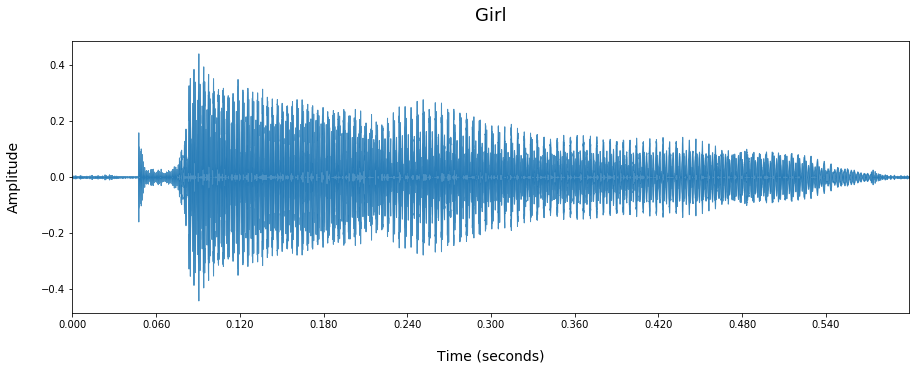

In [20]:
# Plot the isolated waveform for the specific audio sample
plt.figure(figsize=(15, 5))
plt.title('Girl', fontsize=18, pad=20)
librosa.display.waveplot(us_sample_isolated, sr, alpha=0.8)
plt.xlabel('Time (seconds)', fontsize=14, labelpad=20)
plt.ylabel('Amplitude', fontsize=14, labelpad=20)
plt.show();

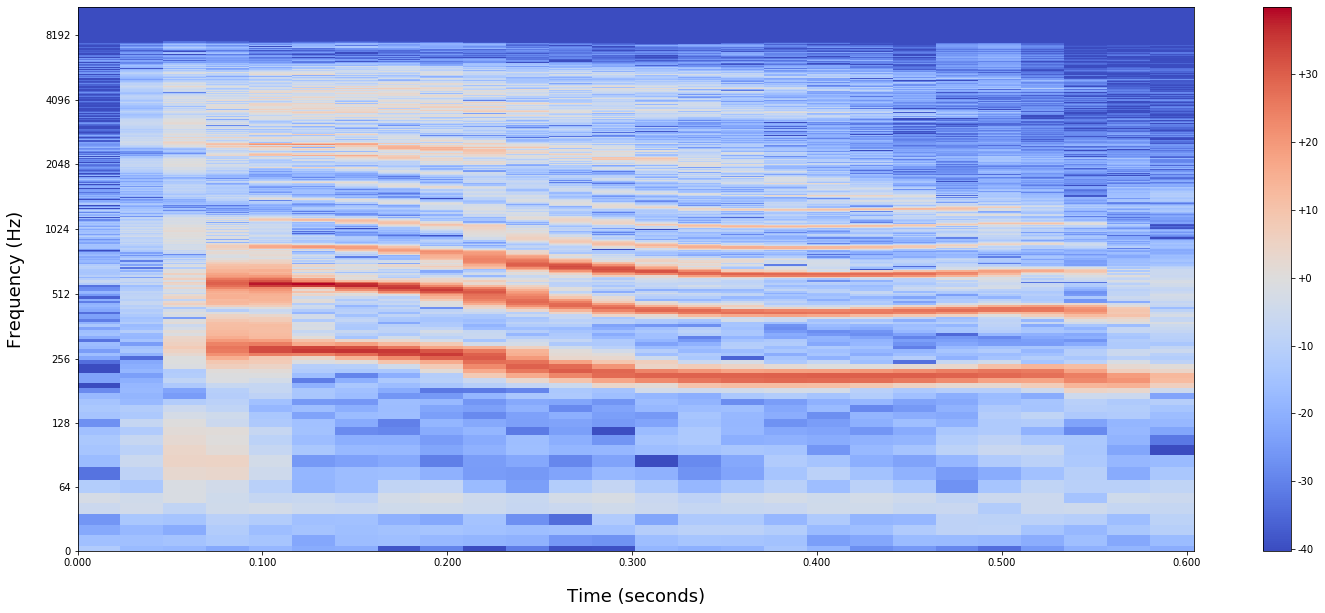

In [38]:
S_us_sample_iso = librosa.stft(us_sample_isolated, n_fft=n_fft, hop_length=hop_length)
Y_us_sample_iso = np.abs(S_us_sample_iso) ** 2

Y_log_us_sample_iso = librosa.power_to_db(Y_us_sample_iso)

# Display spectrogram using log frequency
plot_spectrogram(Y_log_us_sample_iso, sr, hop_length, y_axis='log')